In [1]:
#pip install tensorflow transformers  tf-keras pandas matplotlib seaborn 
from transformers import pipeline
import pandas as pd
import os
import matplotlib as plt
import seaborn as sns

2024-04-17 08:42:13.053851: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 08:42:13.058049: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 08:42:13.117786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 08:42:14.253354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_classifier():
    classifier = pipeline("text-classification", 
                          model="j-hartmann/emotion-english-distilroberta-base", 
                          return_all_scores=True) 
    return classifier

In [3]:
def load_data(in_path):
    data_in = pd.read_csv(in_path)
    data_out = pd.read_csv(in_path)
    data_out[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]] = ""
    return data_in, data_out

In [6]:
def emotion_classifier(data_in, classifier, data_out, out_path):
    for sent in range(len(data_in["Sentence"])):
        sentence = data_in["Sentence"][sent]
        if type(sentence) == str:
            emot_dicts = classifier(sentence)[0]
            scores = []
            for dict in emot_dicts:
                score = dict["score"]
                scores = scores + [score]
            data_out.loc[sent, "anger":"surprise"] = scores
    data_out.to_csv(out_path)
    return data_out

#print("Emotion scores for each sentence in the dataset have been saved to the outfolder")

In [7]:
classifier = load_classifier()
data_in, data_out = load_data("../in/GoT-scripts/Game_of_Thrones_Script.csv")
data_out = emotion_classifier(data_in, classifier, data_out, "../out/emotion_scores.csv")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/home/ucloud/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
def plt_emot_pr_s(out_path):
    data_out = pd.read_csv(out_path)
    data_pr_s = pd.melt(data_out, 
                        id_vars=(['Sentence', 'Season', 'Episode']), 
                        value_vars=["anger", "disgust", 
                                    "fear", "joy", "neutral", 
                                    "sadness", "surprise"])
    
    


In [2]:
#load model
classifier = pipeline("text-classification", 
                      model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/home/ucloud/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [3]:
#load data 
data_in = pd.read_csv("../in/GoT-scripts/Game_of_Thrones_Script.csv")
data_out = pd.read_csv("../in/GoT-scripts/Game_of_Thrones_Script.csv")
#add emotion columns to copy of dataframe
data_out[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]] = ""

In [5]:

for sent in range(len(data_in["Sentence"])):
    sentence = data_in["Sentence"][sent]
    emot_dicts = classifier(sentence)[0]
    scores = []
    for dict in emot_dicts:
        score = dict["score"]
        scores = scores + [score]
    data_out.loc[sent, "anger":"surprise"] = scores
data_out.to_csv("../out/emotion_scores.csv")
    

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [33]:
data_done = data_out.loc[0:5110] #12 minutes on machine 4 to get 5110 rows done 

In [61]:
data_long = pd.melt(data_done, id_vars=(['Sentence', 'Season', 'Episode']), value_vars=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"])

In [ ]:
## plotting 
data = pd.read_csv("../out/emotion_scores.csv")
data_long = pd.melt(data, id_vars=['Season'], value_vars=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"])

In [62]:
data_long

,Sentence,Season,Episode,variable,value
0,What do you expect? They're savages. One lot s...,Season 1,Episode 1,anger,0.094708
1,I've never seen wildlings do a thing like this...,Season 1,Episode 1,anger,0.076113
2,How close did you get?,Season 1,Episode 1,anger,0.049032
3,Close as any man would.,Season 1,Episode 1,anger,0.019147
4,We should head back to the wall.,Season 1,Episode 1,anger,0.138942
...,...,...,...,...,...
35772,That is strange.,Season 2,Episode 5,surprise,0.716431
35773,Move away. Stand back. He's dead.,Season 2,Episode 5,surprise,0.004107
35774,I've taken your castle.,Season 2,Episode 6,surprise,0.006947
35775,Theon?,Season 2,Episode 6,surprise,0.813835


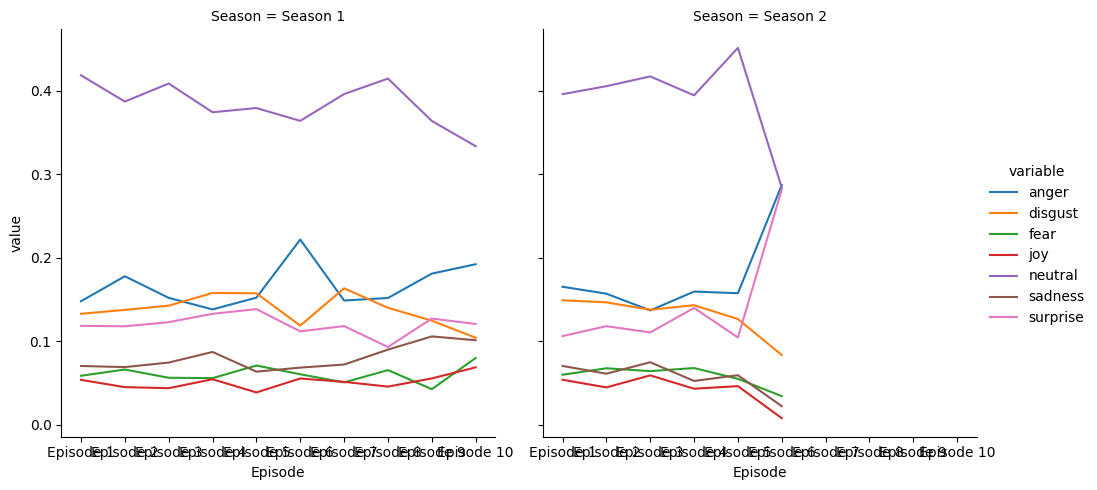

In [66]:
#sns.displot(data_long, x="value", col = "Season", hue = "variable", kde=True)
#sns.displot(data_long, x="value", col = "Season", hue = "variable", kind = "kde", bw_adjust = .2)
#sns.displot(data_long, x="value", hue="variable", col = "Season", multiple="stack")
#sns.catplot(data_long, x="variable", y="value", kind="box", col = "Season")
#sns.catplot(data_long, x="variable", y="value", kind="boxen", col = "Season", hue = "variable")

sns.relplot(x="Episode", y="value", hue="variable", kind = "line", errorbar = None, col = "Season", data=data_long)